# a couple of ways to do two-way ANOVA with Python
Here is my version of [this article](https://www.marsja.se/three-ways-to-carry-out-2-way-anova-with-python/)
There are a lot of errors, and so, I'd fixed it

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
datafile = "ToothGrowth.csv"
data = pd.read_csv(datafile)

C:\Users\monika201103\Anaconda3\lib\site-packages\statsmodels\graphics\factorplots.py:131: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, (values, group) in enumerate(plot_data.groupby(['trace'])):


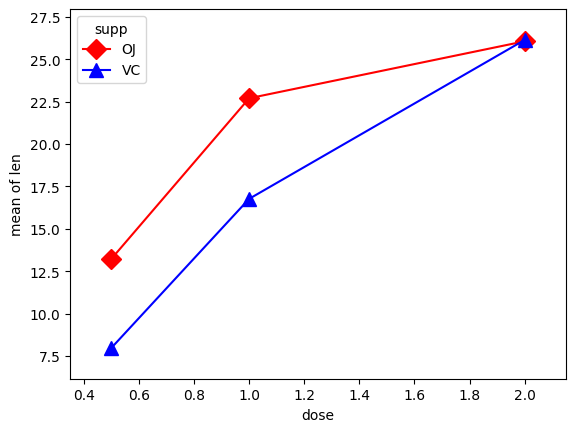

In [3]:
fig = interaction_plot(data.dose, data.supp, data.len,
             colors=['red','blue'], markers=['D','^'], ms=10)

# Calculation of Sum of Squares
The calculations of the sum of squares (the variance in the data) are quite simple using Python. 
First, we start with getting the sample size (N) and the degree of freedoms needed. 
We will use them later to calculate the mean square. 
After we have the degree of freedom we continue with the calculation of the sum of squares.

# Degrees of Freedom

In [4]:
N = len(data.len)
df_a = len(data.supp.unique()) - 1
df_b = len(data.dose.unique()) - 1
df_axb = df_a*df_b 
df_w = N - (len(data.supp.unique())*len(data.dose.unique()))

# Sum of Squares
For the calculation of the sum of squares A, B and Total we will need to have the grand mean. Using Pandas DataFrame method mean on the dependent variable only will give us the grand mean:

In [5]:
grand_mean = data['len'].mean()

# Sum of Squares A – supp
We start with calculation of Sum of Squares for the factor A (supp).

In [6]:
ssq_a = sum([(data[data.supp ==l].len.mean()-grand_mean)**2 for l in data.supp])

# Sum of Squares B – dose
Calculation of the second Sum of Square, B (dose), is pretty much the same but over the levels of that factor.

In [7]:
ssq_b = sum([(data[data.dose ==l].len.mean()-grand_mean)**2 for l in data.dose])

# Sum of Squares Total

In [8]:
ssq_t = sum((data.len - grand_mean)**2)

# Sum of Squares Within (error/residual)
Next, we need to calculate the Sum of Squares Within which is sometimes referred to as error or residual.

In [9]:
vc = data[data.supp == 'VC']
oj = data[data.supp == 'OJ']
vc_dose_means = [vc[vc.dose == d].len.mean() for d in vc.dose]
oj_dose_means = [oj[oj.dose == d].len.mean() for d in oj.dose]

In [10]:
ssq_w = sum(((oj.len - oj_dose_means)**2) + sum((vc.len - vc_dose_means)**2))

# Sum of Squares interaction
Since we have a two-way design we need to calculate the Sum of Squares for the interaction of A and B.

In [11]:
ssq_axb = ssq_t-ssq_a-ssq_b-ssq_w

# Mean Squares
We continue with the calculation of the mean square for each factor, the interaction of the factors, and within.

In [12]:
# Mean Square A
ms_a = ssq_a/df_a

# Mean Square B
ms_b = ssq_b/df_b

# Mean Square AxB
ms_axb = ssq_axb/df_axb

# Mean Square Within/Error/Residual
ms_w = ssq_w/df_w

# F-ratio
The F-statistic is simply the mean square for each effect and the interaction 
divided by the mean square for within (error/residual).

In [13]:
# F-ratio A
f_a = ms_a/ms_w
# F-ratio B
f_b = ms_b/ms_w
# F-ratio AxB
f_axb = ms_axb/ms_w

# Obtaining p-values
We can use the scipy.stats method f.sf to check if our obtained F-ratios is above the critical value. Doing that we need to use our F-value for each effect and interaction as well as the degrees of freedom for them, and the degree of freedom within.

In [14]:
p_a = stats.f.sf(f_a, df_a, df_w)
p_b = stats.f.sf(f_b, df_b, df_w)
p_axb = stats.f.sf(f_axb, df_axb, df_w)

The results are, right now, stored in a lot of variables. To obtain a more readable result we can create a DataFrame that will contain our ANOVA table.

In [15]:
results = {'sum_sq':[ssq_a, ssq_b, ssq_axb, ssq_w],
           'df':[df_a, df_b, df_axb, df_w],
           'F':[f_a, f_b, f_axb, 'NaN'],
            'PR(&gt;F)':[p_a, p_b, p_axb, 'NaN']}
columns=['sum_sq', 'df', 'F', 'PR(&gt;F)']
aov_table1 = pd.DataFrame(results, columns=columns,
                          index=['supp', 'dose', 
                          'supp:dose', 'Residual'])

So, common software, such as SPSS has eta squared as output. However, eta squared is an overestimation of the effect. To get a less biased effect size measure we can use omega squared. The following two functions add eta squared and omega squared to the above DataFrame that contains the ANOVA table.

In [16]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov
eta_squared(aov_table1)
omega_squared(aov_table1)
aov_table1

,sum_sq,df,F,PR(&gt;F),eta_sq,omega_sq
supp,205.350000,1,1.072413,0.305016,0.059484,0.003805
dose,2426.434333,2,6.335868,0.003374,0.702864,0.560823
supp:dose,-9519.710000,2,-24.857719,1.0,-2.757570,-2.717758
Residual,10340.135000,54,NaN,NaN,NaN,NaN





# Two-way ANOVA using Statsmodels
There is, of course, a much easier way to do Two-way ANOVA with Python. We can use Statsmodels which have a similar model notation as many R-packages (e.g., lm). We start with the formulation of the model:

In [17]:
formula = 'len ~ C(supp) + C(dose) + C(supp):C(dose)'
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)

Statsmodels does not calculate effect sizes for us. My functions above can, again, be used and will add omega and eta squared effect sizes to the ANOVA table. Actually, I created these two functions to enable calculation of omega and eta squared effect sizes on the output of Statsmodels anova_lm method. Note, statsmodels can be installed with e.g. pip or conda.

In [18]:
eta_squared(aov_table)
omega_squared(aov_table)
aov_table.round(3)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(supp),205.350,1.0,15.572,0.000,0.059,0.055
C(dose),2426.434,2.0,92.000,0.000,0.703,0.693
C(supp):C(dose),108.319,2.0,4.107,0.022,0.031,0.024
Residual,712.106,54.0,NaN,NaN,NaN,NaN


What is neat with using statsmodels is that we can also do some diagnostics. It is, for instance, very easy to take our model fit (the linear model fitted with the OLS method) and get a Quantile-Quantile (QQplot):

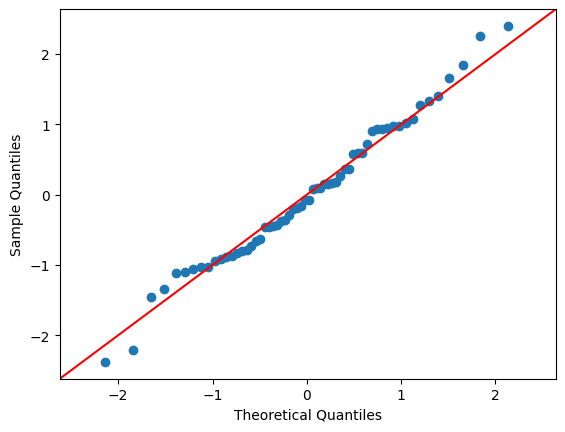

In [19]:
res = model.resid 
fig = sm.qqplot(res, stats.t, fit=True, line="45")
plt.show()

# Two-Way ANOVA using Pingouin
Here, Pingouin offers a very easy way to for ANOVA in Python.
Unfortunatelly, it doesn't work on the Kaggle site (in reason of this library, which i use), but you can copy these few lines of code...

In [20]:
import pingouin as pg
data = pd.read_csv(datafile)
data.head()

,Unnamed: 0,len,supp,dose
0,1,4.2,VC,0.5
1,2,11.5,VC,0.5
2,3,7.3,VC,0.5
3,4,5.8,VC,0.5
4,5,6.4,VC,0.5


In [21]:
aov = pg.anova(data, dv='len', between=['supp', 'dose'], detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,supp,205.350000,1,205.350000,15.571979,2.311828e-04,0.223825
1,dose,2426.434333,2,1213.217167,91.999965,4.046291e-18,0.773109
2,supp * dose,108.319000,2,54.159500,4.106991,2.186027e-02,0.132028
3,Residual,712.106000,54,13.187148,NaN,NaN,NaN


In [22]:
# Thank you!